# AutoEncoder实现FashionMNIST图片重建实战

## Fashion MNIST

Fashion MNIST 是一个定位在比MNIST图片识别问题稍复杂的数据集，它的设定与MNIST几乎完全一样，包含了10类不同类型的衣服、鞋子、包等灰度图片，图片大小为 28 × 28，共 70000 张图片，其中 60000 张用于训练集，10000 张用于测试集，如下图所示，每行是一种类别图片。可以看到，Fashion MNIST除了图片内容与MNIST不一样， 其它设定都相同，大部分情况可以直接替换掉原来基于MNIST训练的算法代码，而不需要额外修改。由于 Fashion MNIST图片识别相对于MNIST 图片更难，因此可以用于测试稍复杂的算法性能。

<img src="FashionMNIST.PNG" width="50%">

[Fashion MNIST官网](https://github.com/zalandoresearch/fashion-mnist)

[更多Keras内置数据集](https://www.tensorflow.org/datasets/catalog/fashion_mnist)


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Sequential,optimizers,losses,datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_moons 
from sklearn.model_selection import train_test_split
import imageio
from PIL import Image

# 加载 Fashion MNIST 图片数据集
(x_train,y_train),(x_test, y_test)=keras.datasets.fashion_mnist.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

#归一化
x_train,x_test=x_train.astype(np.float32)/255.,x_test.astype(np.float32)/255.
#只需要通过图片数据构建数据集对象，不需要标签
batchsz=256
train_db=tf.data.Dataset.from_tensor_slices(x_train)
train_db=train_db.shuffle(batchsz*5).batch(batchsz)
test_db=tf.data.Dataset.from_tensor_slices(x_test)
test_db=test_db.batch(batchsz)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


## Auto-Encoder

我们尝试着利用数据$x$本身作为监督信号来指导网络的训练，即希望神经网络能够学习到映射$f_\theta :x\to x$。

我们把网络$f_\theta$切分为两个部分，前面的子网络尝试学习映射关 系:$g_{\theta 1}: x\to z$，后面的子网络尝试学习映射关系$h_{\theta 2}:z\to x$，如图下图所示。

<img src="autoencoder_f.PNG" width="30%">


我们把$g_{\theta 1}$成一个数据编码(Encode)的过程，把高维度的输入$x$编码成低维度的隐变量$z$(Latent Variable，或隐藏变量)，称为**Encoder网络(编码器)**；$h_{\theta 2}$编码过后的输入$z$解码为高维度的$x$，称为**Decoder网络(解码器)**。

编码器和解码器共同完成了输入数据$x$的编码和解码过程，我们把整个网络模型$f_\theta$叫做**自动编码器(Auto-Encoder)**，简称自编码器。如果使用深层神经网络来参数化$g_{\theta 1}$和$h_{\theta 2}$函数，则称为**深度自编码器(Deep Auto-encoder)**。如下图所示。

<img src="Deep_AutoEncoder.PNG" width="50%">

自编码器能够将输入变换到隐藏向量$z$，并通过解码器重建(Reconstruct，或恢复)出$x$。我们希望解码器的输出能够完美地或者近似恢复出原来的输入，即$x\approx \overline{x}$，那么，自编码器的优化目标可以写成：

$$
Minimize\ \ \  \zeta = dist(x,\overline{x})\\
\overline{x} = h_{\theta 2}(g_{\theta 1}(x))
$$

其中$dist(x,\overline{x})$表示$x$和$\overline{x}$的距离度量，称为重建误差函数。最常见的度量方法有欧氏距离 (Euclidean distance)的平方，计算方法如下：

$$
\zeta = \sum_i(x_i-\overline{x_i})
$$

## 实现

我们利用编码器将输入图片$x\in R^{784}$降维到较低维度的隐藏向量： $h\in R^{20}$，并基于隐藏向量利用解码器重建图片，自编码器模型下图所示，编码器由3层全连接层网络组成，输出节点数分别为256、128、20，解码器同样由3层全连接网络组成，输出节点数分别为128、256、784。

<img src="FashionMNIST_AutoEncoder.PNG" width="60%">

In [2]:
class AE(keras.Model):
    #自编码器模型类，包括了Encoder和Decoder2个子网络
    def __init__(self):
        super(AE,self).__init__()
        #创建Encoders网络
        
        h_dim=30
        
        #创建Encoders网络，实现在自编码器类的初始化函数中
        self.encoder=Sequential([
            layers.Dense(256,activation=tf.nn.relu),
            layers.Dense(128,activation=tf.nn.relu),
            layers.Dense(h_dim)
            ])
        
        
        #创建Decoders网络
        self.decoder=Sequential([
            layers.Dense(128,activation=tf.nn.relu),
            layers.Dense(256,activation=tf.nn.relu),
            layers.Dense(784)
            ])
       
    #接下来将前向传播过程实现在 call 函数中，输入图片首先通过 encoder 子网络得到隐
    #藏向量 h，再通过 decoder 得到重建图片。依次调用编码器和解码器的前向传播函数即可
        
    def call(self,inputs,training=None):
        #前向传播函数
        #获得隐藏向量h,[b,784] => [b,20]
        h=self.encoder(inputs)
        #解码获得重建图片,[b,20] => [b,784]
        x_hat=self.decoder(h)
        
        return x_hat

## 模型训练与保存

In [ ]:
#创建网络对象
model = AE()
model.build(input_shape=(None,784))
model.summary()
optimizer=optimizers.Adam(lr=1e-4)

for epoch in range(120):
    for step,x in enumerate(train_db):
        # 打平，[b, 28, 28] => [b, 784]
        x=tf.reshape(x,[-1,784])
        #构建梯度记录器
        with tf.GradientTape() as tape:
            #前向计算重新获得构建的图片
            x_rec_logits=model(x)
            #计算构建图片与输入之间的损失函数
            rec_loss=tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=x_rec_logits)
            #计算均值
            rec_loss=tf.reduce_mean(rec_loss)
        #自动求导，包含2个子网络的梯度
        grads=tape.gradient(rec_loss,model.trainable_variables)
        #自动更新，同时更新2个子网络
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
        
        if step%100==0:
            print(epoch,step,float(rec_loss))

In [ ]:
model.save_weights('Autoencoder_FM_weights.ckpt') 
print('saved weights.')
del model

## 模型加载与运行

In [3]:
model=AE()
model.load_weights('Autoencoder_FM_weights.ckpt') 
print('loaded weights!')

loaded weights!


`save_images`函数负责将多张图片合并并保存为一张大图，这部分代码使用PIL图片库完成图片阵列逻辑

In [4]:
def save_images(imgs,name):
    #创建280*280大小的图片阵列
    new_im=Image.new('L',(280,280))
    index=0
    for i in range(0,280,28):
        for j in range(0,280,28):
            im=imgs[index]
            im=Image.fromarray(im,mode='L')
            new_im.paste(im,(i,j))#写入对应位置
            index+=1
    #保存图片阵列
    new_im.save(name)

In [5]:
x=next(iter(test_db))
logits=model(tf.reshape(x,[-1,784]))
x_hat=tf.sigmoid(logits)
x_hat=tf.reshape(x_hat,[-1,28,28])

#输入的前50张+重建的前50张图片合并，[b,28,28]=>[2b,28,28]
x_concat=tf.concat([x[:50],x_hat[:50]],axis=0)
x_concat=x_concat.numpy()*255.
x_concat=x_concat.astype(np.uint8)#转换为整型
save_images(x_concat,'AutoEncoder_FashionMNIST.png')

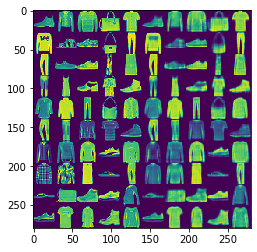

In [6]:
image_value = imageio.imread('AutoEncoder_FashionMNIST.png')
plt.imshow(image_value)
plt.show()